# XGBoost Setup
Import relevant libraries and setup our dataframe.

In [17]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix,classification_report

df = pd.read_csv("../Data/Transformed_Student_Performence_Data.csv")

X = df.drop("GradeClass", axis=1)
y = df["GradeClass"]

# Train Model
Split our train and test data to then fit the model with the weighted classes.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

search_space = {
	"max_depth": Integer(3, 10),
	"learning_rate": Real(0.01, 0.3, prior="log-uniform"),
	"subsample": Real(0.5, 1.0),
	"colsample_bytree": Real(0.5, 1.0)
}

model = xgb.XGBClassifier(
	# this objective is used for multi-class classifcation problems, which is what we have
	# https://xgboosting.com/configure-xgboost-multisoftprob-objective/
	objective="multi:softprob",
	eval_metric="mlogloss",
	n_estimators=100,
	# seed keeps our results the same, 42 happens to be the answer to life
	random_state=42,
	# parameters optimised by skopt
	colsample_bytree=0.7,
	learning_rate=0.3,
	max_depth=3,
	subsample=0.5
)

sample_weights = np.array([class_weight_dict[i] for i in y_train])
model.fit(X_train, y_train, sample_weight=sample_weights)

y_pred = model.predict(X_test)

Here we output the optimised parameters yielding the highest score to be used with the model.

In [19]:
bayes_search = BayesSearchCV(estimator=model, search_spaces=search_space, n_iter=25, cv=3, n_jobs=-1)
bayes_search.fit(X_train, y_train)

print(f"Best parameters: {bayes_search.best_params_}")
print(f"Best score: {bayes_search.best_score_}")

Best parameters: OrderedDict({'colsample_bytree': 1.0, 'learning_rate': 0.13294977561074753, 'max_depth': 3, 'subsample': 0.5})
Best score: 0.7987373874073381


# Evaluation
Classification report provides model accuracy and normalised confusion matrix provides visual overview of the model"s performance across it"s predictions.

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.56      0.60        16
           1       0.55      0.65      0.60        49
           2       0.61      0.57      0.59        80
           3       0.59      0.65      0.61        85
           4       0.95      0.90      0.92       249

    accuracy                           0.77       479
   macro avg       0.67      0.67      0.67       479
weighted avg       0.78      0.77      0.77       479



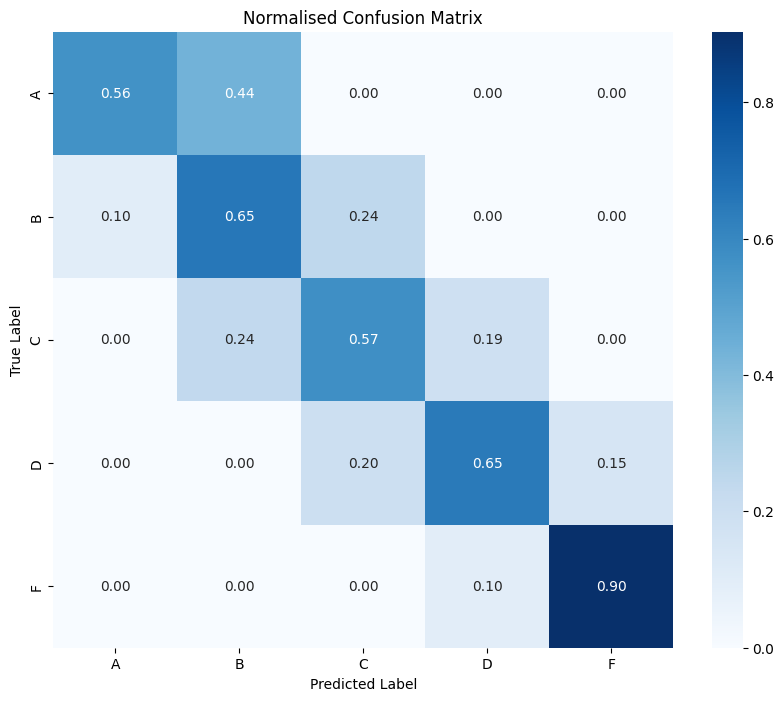

In [21]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

grade_classes = ["A", "B", "C", "D", "F"]
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
	xticklabels=grade_classes,
	yticklabels=grade_classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalised Confusion Matrix")
plt.show()